# Preamble

In [10]:
# change this to the appropriate path
DataDir = '/Users/kvantilburg/Documents/gaia_edr3/cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/'

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.gaia import Gaia
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from time import time as tictoc
import pandas as pd
import seaborn as sns
from os import listdir
import gzip
from tqdm import tqdm, tqdm_notebook
from time import time as tictoc


from IPython.core.display import display, HTML
from IPython.display import display, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})
#rc('text', usetex=True)

from MyUnits import *

# Functions

In [11]:
def fn_is_double(coord_1, coord_2, cutoff = 5 * arcsec):
    return coord_1.separation(coord_2).value * degree < cutoff

# Tests

## Loading files

In [15]:
list_files = listdir(DataDir); 
list_files = [file for file in list_files if file[-7:]=='.csv.gz'] #select only files ending with 'csv.gz'
print(list_files[0:10])
len(list_files)

['GaiaSource_762399-762484.csv.gz', 'GaiaSource_047061-047323.csv.gz', 'GaiaSource_236572-236697.csv.gz', 'GaiaSource_647616-647753.csv.gz', 'GaiaSource_596549-596713.csv.gz', 'GaiaSource_684931-685004.csv.gz', 'GaiaSource_679973-680038.csv.gz', 'GaiaSource_512147-512207.csv.gz', 'GaiaSource_659429-659576.csv.gz', 'GaiaSource_665996-666017.csv.gz']


3386

In [16]:
f = gzip.open(DataDir+list_files[0], 'rb')
tab = pd.read_csv(f)
f.close()

In [17]:
tab

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
0,1636042515805110273,Gaia EDR3 6706132524039944320,6706132524039944320,1093314136,2016.0,272.900316,0.084036,-49.306978,0.080154,0.260364,0.098281,2.649183,4.542772,-1.741593,0.098834,-4.195668,0.081512,0.208446,0.053351,-0.339154,-0.299689,-0.309200,-0.247804,-0.515948,-0.203596,0.199817,0.176028,331,0,331,0,1.545066,381.71085,0.161205,4.493875e-01,31,False,1.503481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,19,0.150419,38,18,0,0.041676,11.564567,0,0,1.060073,0.270741,0.153525,0.247684,0.673580,-117.921340,0.309337,-28.775400,-42.715717,False,328,1559.537091,1.640209,950.816300,17.704878,35,767.525988,5.904874,129.981770,18.125809,36,1128.792121,7.210201,156.554890,17.116360,0.0,1.0,0.0,1.0,0.0,1.215949,1.009449,0.420931,0.588518,NaN,NaN,0,NaN,NaN,NaN,344.417622,-14.204075,272.101556,-25.888853
1,1636042515805110273,Gaia EDR3 6706132524039956096,6706132524039956096,683796199,2016.0,272.896404,0.092123,-49.297646,0.086429,0.412165,0.106462,3.871471,6.336978,-5.058659,0.106314,-3.816709,0.086763,0.240984,0.114024,-0.360116,-0.307112,-0.251743,-0.270581,-0.528553,-0.222581,0.176461,0.190569,322,0,321,1,1.437428,367.66953,0.215563,6.639538e-01,31,False,1.504352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,18,0.163626,37,18,0,0.053035,16.039360,0,0,1.056645,0.251294,0.157199,0.224545,0.666236,-114.227840,-6.153005,-30.536040,-42.234974,False,320,1467.590636,1.789683,820.028140,17.770855,35,760.178630,11.435810,66.473526,18.136253,35,1038.539376,6.110423,169.961960,17.206839,0.0,0.0,0.0,0.0,0.0,1.225626,0.929415,0.365398,0.564016,NaN,NaN,0,NaN,NaN,NaN,344.425202,-14.197783,272.098954,-25.879466
2,1636042515805110273,Gaia EDR3 6706132524039959808,6706132524039959808,686784167,2016.0,272.905592,0.074299,-49.294586,0.072329,0.257130,0.085632,3.002742,3.749344,3.619239,0.088522,-0.979127,0.074578,0.165138,0.048495,-0.359756,-0.231192,-0.274081,-0.190526,-0.561518,-0.182445,0.164077,0.130772,318,0,317,1,1.465938,363.50190,0.200587,9.001404e-01,31,False,1.527729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,19,0.132855,37,18,0,0.052460,12.050510,0,0,1.058166,0.269482,0.148990,0.212256,0.665387,-124.736626,3.958485,-28.199392,-42.838120,False,317,2016.459860,1.796555,1122.403800,17.425894,33,1028.405293,8

## Routine test

In [19]:
nside = 2**20
npix = hp.nside2npix(nside)
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / arcsec)[0:7],' arcsec')

nside = 1048576 , npix = 13194139533312
linear pixel size = 0.20129  arcsec


In [29]:
#for i_f, f in tqdm(enumerate(list_files[0:1])):
angle_cutoff = 3 * arcsec;
parallax_cutoff = 2;
parallax_sigma = 2;
df_1 = pd.DataFrame([],columns=tab.columns)
df_2 = pd.DataFrame([],columns=tab.columns)

for i_f in tqdm(range(len(list_files[:2]))):
    ### open file and load table ###
    f = gzip.open(DataDir+list_files[i_f], 'rb')
    tab = pd.read_csv(f)
    f.close()
    ### load into healpix ###
    tab = tab.loc[(tab['astrometric_params_solved']==31) | (tab['astrometric_params_solved']==95)] # only look at stars with pm 
    tab_1 = tab.loc[tab['parallax'] - parallax_sigma * tab['parallax_error'] > parallax_cutoff] # foreground stars
    tab_2 = tab.loc[tab['parallax'] + parallax_sigma * tab['parallax_error'] < parallax_cutoff] # background stars
    q_pix_1 = np.asarray(hp.ang2pix(nside,tab_1['l'].to_numpy(),tab_1['b'].to_numpy(),lonlat=True)) # pixels of foreground stars
    q_pix_2 = np.asarray(hp.ang2pix(nside,tab_2['l'].to_numpy(),tab_2['b'].to_numpy(),lonlat=True)) # pixels of background stars
    #occ_pixels_1 = np.unique(q_pix_1) # list of unique occupied pixels
    occ_pixels_2 = np.unique(q_pix_2) # list of unique occupied pixels
    ### loop over foreground stars ###
    #for i_1,q_1 in tqdm(enumerate(q_pix_1),position=0):
    for i_1,q_1 in enumerate(q_pix_1):
        vec_1 = hp.pix2vec(nside,q_1)
        #nb_pix_1 = np.append(hp.get_all_neighbours(nside, q_1, lonlat=True),q_1)
        nb_pix_1 = hp.query_disc(nside, vec_1, 5*arcsec)
        nb_pix_2 = np.intersect1d(occ_pixels_2,nb_pix_1,assume_unique=True)
        if len(nb_pix_2)>0:
            coord_1 = SkyCoord(ra = tab_1['ra'].iloc[i_1] * u.deg, dec = tab_1['dec'].iloc[i_1] * u.deg)
            nb_idx_2 = np.intersect1d(q_pix_2,nb_pix_1,return_indices=True)[1]
            for i_2 in nb_idx_2:
                coord_2 = SkyCoord(ra = tab_2['ra'].iloc[i_2] * u.deg, dec = tab_2['dec'].iloc[i_2] * u.deg)
                if fn_is_double(coord_1,coord_2,cutoff = angle_cutoff):
                    df_1 = df_1.append(tab_1.iloc[i_1],ignore_index=True)
                    df_2 = df_2.append(tab_2.iloc[i_2],ignore_index=True)

100%|██████████| 2/2 [02:10<00:00, 65.34s/it]


In [83]:
len(df_1), len(df_2)

(863, 863)

In [41]:
np.asarray([[df_1['ra'],df_1['dec'],df_1['parallax']],[df_2['ra'],df_2['dec'],df_2['parallax']]])

array([[[ 2.73104923e+02,  2.73139196e+02,  2.72889225e+02, ...,  9.68462405e+00,  9.21196795e+00,  9.45693738e+00],
        [-4.92068728e+01, -4.91800998e+01, -4.91837137e+01, ...,  5.28999229e+01,  5.27904414e+01,  5.28892252e+01],
        [ 3.23119811e+00,  3.30431523e+00,  2.44853947e+00, ...,  3.93953992e+00,  3.40163604e+00,  2.52085560e+00]],

       [[ 2.73105597e+02,  2.73139323e+02,  2.72890328e+02, ...,  9.68384959e+00,  9.21096693e+00,  9.45624044e+00],
        [-4.92069408e+01, -4.91804554e+01, -4.91834324e+01, ...,  5.28998051e+01,  5.27903212e+01,  5.28892588e+01],
        [ 8.42667141e-02,  5.59111484e-01,  1.02808559e-01, ...,  1.89046065e+00, -1.49161255e-01,  1.07470205e-01]]])

# Parallel routine

In [85]:
nside = 2**20
npix = hp.nside2npix(nside)
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / arcsec)[0:7],' arcsec')

nside = 1048576 , npix = 13194139533312
linear pixel size = 0.20129  arcsec


In [86]:
def fn_find_pairs(i_f):
    DataDir = '/Users/kvantilburg/Documents/gaia_edr3/cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/'
    list_files = listdir(DataDir); 
    list_files = [file for file in list_files if file[-6:]=='csv.gz'] #select only files ending with 'csv.gz'
    file = list_files[i_f]
    try:
        ### parameters ###
        angle_cutoff = 3 * arcsec;
        parallax_cutoff = 2;
        parallax_sigma = 2;
        ### open file and load table ###
        f = gzip.open(DataDir+list_files[i_f], 'rb')
        tab = pd.read_csv(f)
        f.close()
        ### load into healpix ###
        tab = tab.loc[(tab['astrometric_params_solved']==31) | (tab['astrometric_params_solved']==95)] # only look at stars with pm 
        tab_1 = tab.loc[tab['parallax'] - parallax_sigma * tab['parallax_error'] > parallax_cutoff] # foreground stars
        tab_2 = tab.loc[tab['parallax'] + parallax_sigma * tab['parallax_error'] < parallax_cutoff] # background stars
        q_pix_1 = np.asarray(hp.ang2pix(nside,tab_1['l'].to_numpy(),tab_1['b'].to_numpy(),lonlat=True)) # pixels of foreground stars
        q_pix_2 = np.asarray(hp.ang2pix(nside,tab_2['l'].to_numpy(),tab_2['b'].to_numpy(),lonlat=True)) # pixels of background stars
        df_1 = pd.DataFrame([],columns=tab.columns)
        df_2 = pd.DataFrame([],columns=tab.columns)
        #occ_pixels_1 = np.unique(q_pix_1) # list of unique occupied pixels
        occ_pixels_2 = np.unique(q_pix_2) # list of unique occupied pixels
        ### loop over foreground stars ###
        #for i_1,q_1 in tqdm(enumerate(q_pix_1),position=0):
        for i_1,q_1 in enumerate(q_pix_1):
            vec_1 = hp.pix2vec(nside,q_1)
            #nb_pix_1 = np.append(hp.get_all_neighbours(nside, q_1, lonlat=True),q_1)
            nb_pix_1 = hp.query_disc(nside, vec_1, 5*arcsec)
            nb_pix_2 = np.intersect1d(occ_pixels_2,nb_pix_1,assume_unique=True)
            if len(nb_pix_2)>0:
                coord_1 = SkyCoord(ra = tab_1['ra'].iloc[i_1] * u.deg, dec = tab_1['dec'].iloc[i_1] * u.deg)
                nb_idx_2 = np.intersect1d(q_pix_2,nb_pix_1,return_indices=True)[1]
                for i_2 in nb_idx_2:
                    coord_2 = SkyCoord(ra = tab_2['ra'].iloc[i_2] * u.deg, dec = tab_2['dec'].iloc[i_2] * u.deg)
                    if fn_is_double(coord_1,coord_2,cutoff = angle_cutoff):
                        df_1 = df_1.append(tab_1.iloc[i_1],ignore_index=True)
                        df_2 = df_2.append(tab_2.iloc[i_2],ignore_index=True)
        df_1.to_csv(DataDir+list_files[i_f][:-7]+'_pairs_foreground.csv')
        df_2.to_csv(DataDir+list_files[i_f][:-7]+'_pairs_background.csv')
        return len(df_1)
    except:
        return file

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

inputs = range(len(list_files)) 

num_cores = 12 #multiprocessing.cpu_count()

tic = tictoc()
out = Parallel(n_jobs=num_cores)(delayed(fn_find_pairs)(i_f) for i_f in tqdm(inputs))
toc = tictoc()
print(toc - tic)

# Collect results

In [88]:
list_files = listdir(DataDir)
list_files.sort()
list_files_pairs_foreground = [file for file in list_files if file[-21:]=='_pairs_foreground.csv'] #select foreground files
list_files_pairs_background = [file for file in list_files if file[-21:]=='_pairs_background.csv']#select background files

In [89]:
dat_fore = []
dat_back = []
for i_f in tqdm(range(len(list_files_pairs_foreground[:]))):
    df_foreground_tmp = pd.read_csv(DataDir+list_files_pairs_foreground[i_f])
    df_background_tmp = pd.read_csv(DataDir+list_files_pairs_background[i_f])
    dat_fore_tmp = df_foreground_tmp.values.tolist()
    dat_back_tmp = df_background_tmp.values.tolist()
    for row in dat_fore_tmp:
        dat_fore.append(row[1:])
    for row in dat_back_tmp:
        dat_back.append(row[1:])

100%|██████████| 3386/3386 [06:47<00:00,  8.31it/s]  


In [90]:
df_foreground = pd.DataFrame(data = dat_fore, columns=tab.columns)
df_background = pd.DataFrame(data = dat_back, columns=tab.columns)

In [91]:
df_foreground.to_csv(DataDir+'pairs_foreground.csv')
df_background.to_csv(DataDir+'pairs_background.csv')

In [92]:
df_foreground

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
0,1636042515805110273,Gaia EDR3 44362718023680,44362718023680,416893672,2016.0,45.505552,0.032692,0.495902,0.031585,9.547125,0.040051,238.371440,34.418854,24.173422,0.040574,-24.501086,0.036580,-0.079496,0.267700,0.186356,-0.118394,-0.378046,-0.201487,0.088202,0.247449,-0.001046,-0.033264,176,0,169,7,1.503196,194.26805,0.117198,1.985373,31,False,1.272564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,14,0.058099,22,7,0,0.048605,73.82487,0,0,1.082051,0.325767,0.086170,0.397960,0.933559,-96.521880,-8.451236,-48.899506,27.634140,False,151,16257.411715,17.428204,932.82200,15.159739,11,3182.874064,56.530610,56.303550,16.581493,12,20861.349000,95.351970,218.782580,13.949539,0.0,0.0,1.0,1.0,0.0,1.478970,2.631954,1.421755,1.210199,NaN,NaN,0,NaN,NaN,NaN,176.951517,-48.194514,43.189893,-16.009114
1,1636042515805110273,Gaia EDR3 517530674915456,517530674915456,57650288,2016.0,44.529505,0.014845,1.871717,0.014266,11.629276,0.019408,599.185500,26.247091,25.596804,0.019765,5.806323,0.019325,0.028185,0.163970,-0.149826,0.084696,-0.416653,0.189183,0.172180,-0.070307,-0.365089,0.264694,203,142,203,0,1.221809,361.72992,0.084335,6.865138,31,True,1.359511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,14,0.030930,23,9,0,0.021958,164.02924,0,0,1.060305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,201,128877.397444,49.749607,2590.52100,12.911925,20,39823.602378,113.376620,351.250580,13.838191,22,133216.716889,448.546600,296.996370,11.936499,4.0,1.0,0.0,0.0,0.0,1.342674,1.901692,0.926266,0.975427,7.366274,1.60656,7,4000.0,3.0,0.0,174.462639,-47.915649,42.637977,-14.408659
2,1636042515805110273,Gaia EDR3 605968345930752,605968345930752,1684205779,2016.0,46.735866,0.113192,1.702547,0.107038,5.472961,0.145823,37.531600,48.571820,-38.974153,0.137334,-28.986846,0.132732,-0.092791,0.272981,0.058479,-0.177069,-0.464067,-0.197718,-0.056110,0.062055,0.062678,0.156501,148,0,146,2,0.716103,163.07938,0.107254,0.132361,31,False,1.242420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,13,0.202771,17,6,0,0.032198,160.99312,0,0,1.040548,0.380879,0.148138,0.485008,0.898813,-82.146095,-10.326653,-52.686764,28.022078,False,147,1757.695525,2.866623,613.15890,17.575008,6,264.744081,15.522827,17.055145,19.281477,7,2405.174284,38.333073,62.744102,16.2950

In [93]:
df_background

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
0,1636042515805110273,Gaia EDR3 44362718024064,44362718024064,1420702209,2016.0,45.506006,0.422303,0.495456,0.468631,-0.145891,0.517803,-0.281750,0.988165,0.934795,0.548966,0.320357,0.559484,0.166815,0.191052,0.283550,-0.104956,-0.375651,-0.182569,0.081149,0.200957,0.126494,0.174756,151,0,149,2,3.226531,210.56114,1.936215,5.293657,95,False,NaN,1.535788,0.120194,-0.118143,-0.124186,0.097170,0.011379,0.070946,19,15,0.837888,20,6,1,0.146171,71.589550,0,0,1.194259,0.275409,0.134283,0.346104,0.924548,-82.372400,-38.645123,-52.183216,27.813862,False,139,397.428935,1.507073,263.70908,19.189219,2,471.718821,250.214920,1.885255,18.654335,2,1249.424854,427.749540,2.920926,17.006120,0.0,2.0,0.0,2.0,1.0,4.330696,1.648214,-0.534883,2.183098,NaN,NaN,0,NaN,NaN,NaN,176.952471,-48.194496,43.190211,-16.009672
1,1636042515805110273,Gaia EDR3 517530674915328,517530674915328,1638356084,2016.0,44.530163,0.026800,1.871534,0.026163,1.398818,0.035111,39.840324,10.888395,-3.446384,0.035430,-10.328582,0.034289,0.044942,0.177926,-0.133827,0.107463,-0.399769,0.213576,0.179276,-0.065758,-0.351450,0.254519,203,0,200,3,15.095873,677.21173,0.180998,13.377549,31,False,1.545734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,14,0.055043,23,9,0,0.016747,169.063870,23,0,1.852693,0.363849,0.172375,0.452322,0.856875,-86.098816,-23.717506,-46.810840,28.885748,False,192,42684.624574,12.907432,3306.98050,14.111689,10,23293.838537,86.233475,270.125240,14.420440,11,30840.710912,276.830260,111.406570,13.525085,10.0,0.0,10.0,1.0,0.0,1.268245,0.895355,0.308751,0.586604,NaN,NaN,0,NaN,NaN,NaN,174.463533,-47.915322,42.638571,-14.409026
2,1636042515805110273,Gaia EDR3 605968348766080,605968348766080,696569398,2016.0,46.735399,0.112511,1.701974,0.103523,0.180929,0.143213,1.263363,7.864618,5.613876,0.134982,-5.507869,0.124928,-0.134175,0.312954,0.103900,-0.148548,-0.457335,-0.187683,-0.005263,0.085050,0.060505,0.080255,150,0,148,2,2.493493,196.29137,0.376122,2.099638,31,False,1.575708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,13,0.191545,17,6,0,0.006396,150.134630,0,0,1.148567,0.385042,0.151055,0.493602,0.899137,-85.960270,-7.939474,-51.829930,27.980309,False,148,2078.825165,2.781762,747.30530,17.392822,13,1180.050986,19.846960,59.45

# Maps

In [5]:
df_foreground = pd.read_csv(DataDir+'pairs_foreground.csv')
df_background = pd.read_csv(DataDir+'pairs_background.csv')

In [6]:
nside = 2**7
npix = hp.nside2npix(nside)
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / arcsec)[0:7],' arcsec')

nside = 128 , npix = 196608
linear pixel size = 1649.03  arcsec


In [96]:
q_pix_1 = hp.ang2pix(nside,df_foreground['l'],df_foreground['b'],lonlat=True)
q_pix_2 = hp.ang2pix(nside,df_background['l'],df_background['b'],lonlat=True)
pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

In [97]:
map_count_1 = np.zeros(hp.nside2npix(nside));
map_count_2 = np.zeros(hp.nside2npix(nside));
for idx, ipix in tqdm(enumerate(q_pix_1)):
    map_count_1[ipix] += 1
for idx, ipix in tqdm(enumerate(q_pix_2)):
    map_count_2[ipix] += 1

4057114it [00:03, 1140809.33it/s]
4057114it [00:03, 1110559.90it/s]


/Users/kvantilburg/opt/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


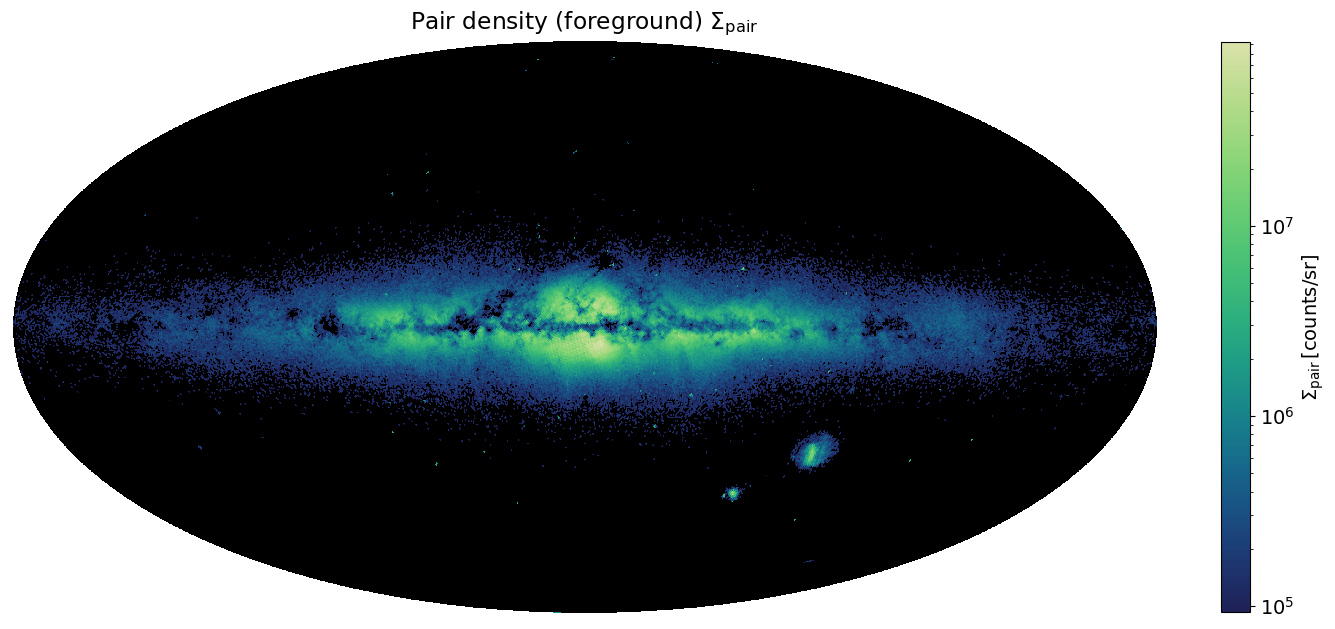

In [98]:
map = 1e-10 + map_count_1 / (hp.pixelfunc.nside2resol(nside))**2 
map_min = 1e-3 * np.max(map); map_max = np.max(map); 
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = True, as_cmap=True)
#cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
cmap.set_under(cmap(0)); cmap.set_bad(cmap(0)); cmap.set_over(cmap(1));
#cmap.set_under('white'); cmap.set_over('black')
plt.subplots(1,1,figsize=(16,8))
hp.mollview(map, title=r"Pair density (foreground) $\Sigma_\mathrm{pair}$", cmap=cmap,cbar=None, 
            bgcolor='black',badcolor='white',min=map_min,max=map_max,xsize=5000,hold=True,
            norm=mpl.colors.LogNorm(vmin=map_min,vmax=map_max))
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$')
#fig.savefig('quasars_pm_mag_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

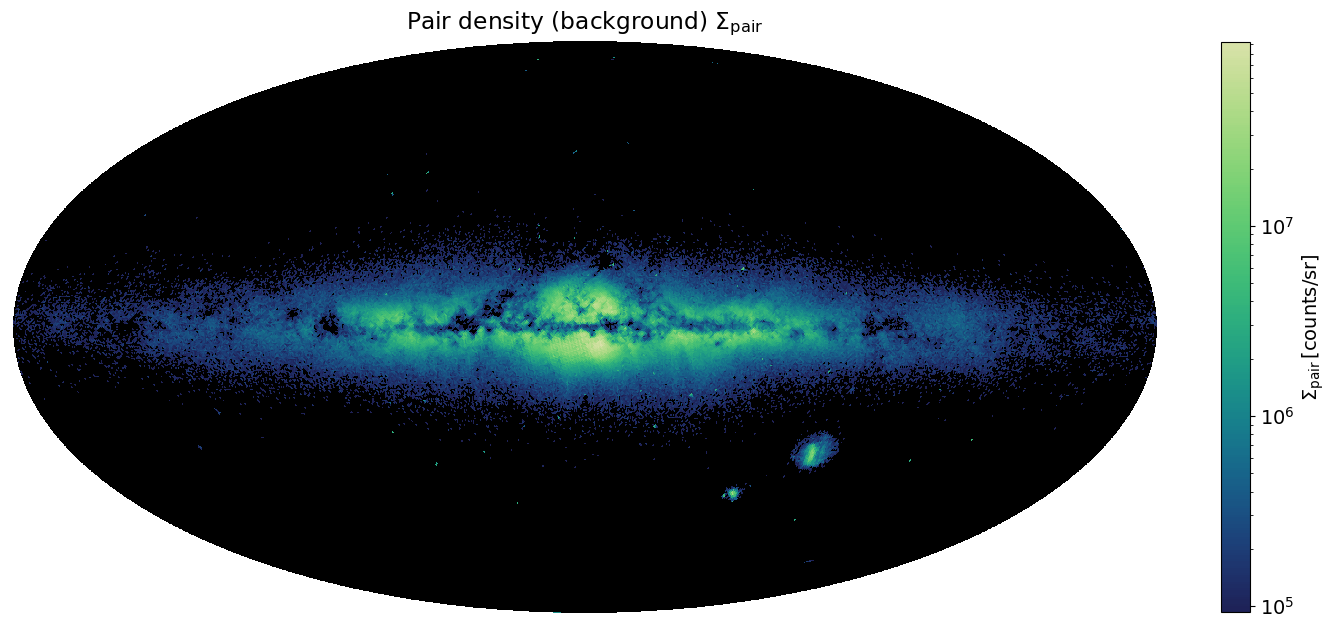

In [99]:
map = 1e-10 + map_count_2 / (hp.pixelfunc.nside2resol(nside))**2 
map_min = 1e-3 * np.max(map); map_max = np.max(map); 
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = True, as_cmap=True)
#cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
cmap.set_under(cmap(0)); cmap.set_bad(cmap(0)); cmap.set_over(cmap(1));
#cmap.set_under('white'); cmap.set_over('black')
plt.subplots(1,1,figsize=(16,8))
hp.mollview(map, title=r"Pair density (background) $\Sigma_\mathrm{pair}$", cmap=cmap,cbar=None, 
            bgcolor='black',badcolor='white',min=map_min,max=map_max,xsize=5000,hold=True,
            norm=mpl.colors.LogNorm(vmin=map_min,vmax=map_max))
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$')
#fig.savefig('quasars_pm_mag_map.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

# Histograms

In [7]:
dec_1 = np.asarray(df_foreground['dec'])
dec_2 = np.asarray(df_background['dec'])
ra_1 = np.asarray(df_foreground['ra'])
ra_2 = np.asarray(df_background['ra'])
parallax_1 = np.asarray(df_foreground['parallax'])
parallax_2 = np.asarray(df_background['parallax'])
parallax_error_1 = np.asarray(df_foreground['parallax_error'])
parallax_error_2 = np.asarray(df_background['parallax_error'])

In [19]:
list_sep = []
size = 10000;
for i in tqdm(range(10)):
    list_i = np.random.randint(low = 0, high = len(df_foreground), size = size)
    #list_i = range(i,np.min([i+step,len(df_foreground)]));
    coord_1 = SkyCoord(ra = df_foreground['ra'].iloc[list_i] * u.deg, dec = df_foreground['dec'].iloc[list_i] * u.deg)
    coord_2 = SkyCoord(ra = df_background['ra'].iloc[list_i] * u.deg, dec = df_background['dec'].iloc[list_i] * u.deg)
    sep = coord_1.separation(coord_2).value*degree
    list_sep.append(sep)
list_sep = np.asarray(list_sep).flatten()

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


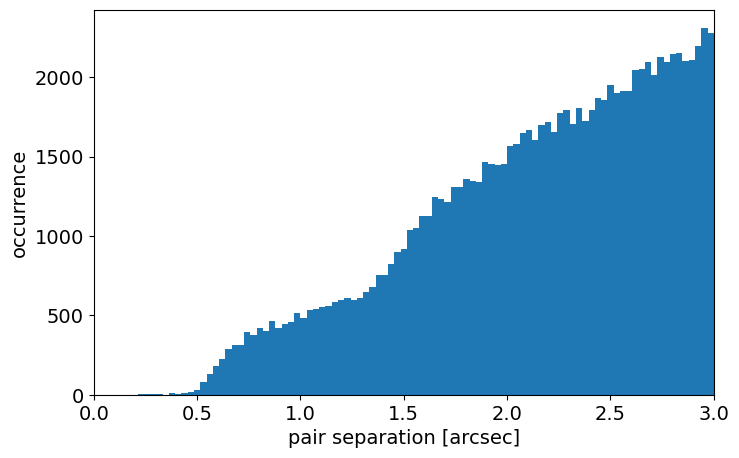

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(list_sep/arcsec,bins=np.linspace(0,3,100));
ax.set_xlim(0,3); ax.set_ylim(0,);
ax.set_xlabel('pair separation [arcsec]'); ax.set_ylabel('occurrence');

In [82]:
parallax = np.concatenate([parallax_1,parallax_2])
parallax_fracerr = np.concatenate([np.abs(parallax_1/parallax_error_1),np.abs(parallax_2/parallax_error_2)])
hist_parallax, edges_x, edges_y = np.histogram2d(parallax,parallax_fracerr,bins=[np.arange(-10.0,100,0.1),np.logspace(-1,3,100)])
X, Y = np.meshgrid(edges_x,edges_y)
hist_parallax = np.transpose(hist_parallax)

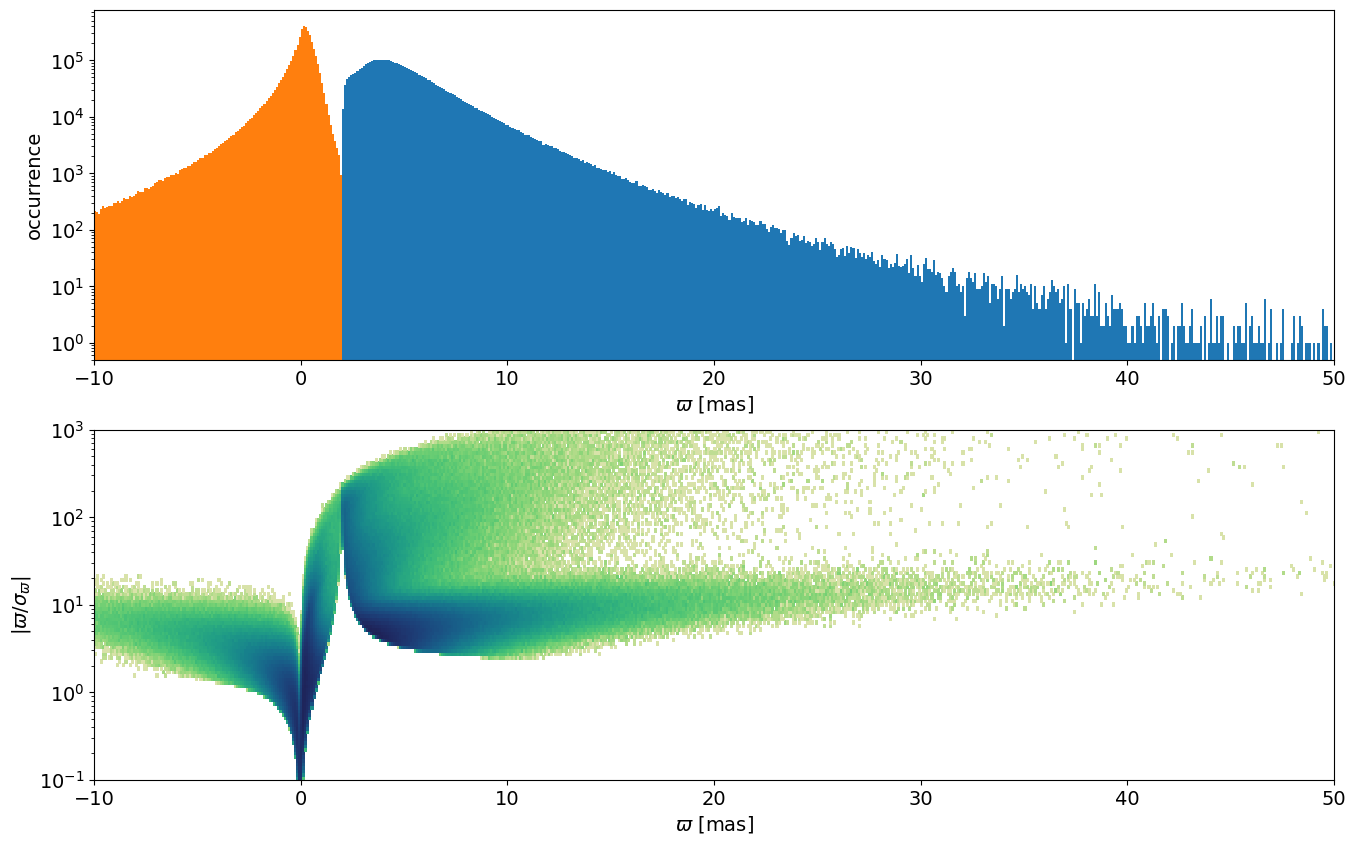

In [85]:
xlim = -10,50
fig, ax = plt.subplots(2,1,figsize=(16,10))
ax[0].hist(parallax_1,bins=np.arange(-10.0,100,0.1),log=True);
ax[0].hist(parallax_2, bins=np.arange(-10.0,100,0.1),log=True);
ax[0].set_xlim(xlim); ax[0].set_ylim(0.5,);
ax[0].set_xlabel(r'$\varpi$ [mas]'); ax[0].set_ylabel('occurrence');
#cmap = "cubehelix_r"
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = False, as_cmap=True)
ax[1].pcolor(X,Y,hist_parallax,cmap = cmap,norm=mpl.colors.LogNorm());
ax[1].set_yscale('log')
ax[1].set_xlim(xlim);
ax[1].set_xlabel(r'$\varpi$ [mas]'); ax[1].set_ylabel(r'$|\varpi/\sigma_{\varpi}|$');